In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Reshape((-1, shape, )),
    layers.LSTM(1024, activation="swish"),
    layers.Dense(128, activation="swish", kernel_regularizer=regularizers.l2(0.002)),
    layers.BatchNormalization(),
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002))
])

model.compile(optimizer=optimizers.Adam(0.0003), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=15, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('lstm')

Epoch 1/15
2360/2360 [==============================] - 299s 125ms/step - loss: 1.1412 - mae: 0.7109 - mape: 792.1526 - val_loss: 1.0162 - val_mae: 0.7187 - val_mape: 6195.7783
Epoch 2/15
2360/2360 [==============================] - 304s 129ms/step - loss: 0.9262 - mae: 0.7055 - mape: 763.9545 - val_loss: 0.9236 - val_mae: 0.7193 - val_mape: 2439.5623
Epoch 3/15
2360/2360 [==============================] - 301s 128ms/step - loss: 0.9009 - mae: 0.7048 - mape: 792.0078 - val_loss: 0.9199 - val_mae: 0.7126 - val_mape: 3547.0059
Epoch 4/15
2360/2360 [==============================] - 300s 127ms/step - loss: 0.8963 - mae: 0.7041 - mape: 623.6749 - val_loss: 0.9239 - val_mae: 0.7163 - val_mape: 3925.3689
Epoch 5/15
2360/2360 [==============================] - 302s 128ms/step - loss: 0.8936 - mae: 0.7037 - mape: 553.7492 - val_loss: 0.9105 - val_mae: 0.7137 - val_mape: 3074.5850
Epoch 6/15
2360/2360 [==============================] - 299s 127ms/step - loss: 0.8915 - mae: 0.7032 - mape: 608.32

INFO:tensorflow:Assets written to: lstm\assets


INFO:tensorflow:Assets written to: lstm\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 80s 9ms/step


,predict
count,281840.000000
mean,0.000161
std,0.003952
min,-0.054659
25%,-0.001775
50%,-0.000018
75%,0.002009
max,0.081125


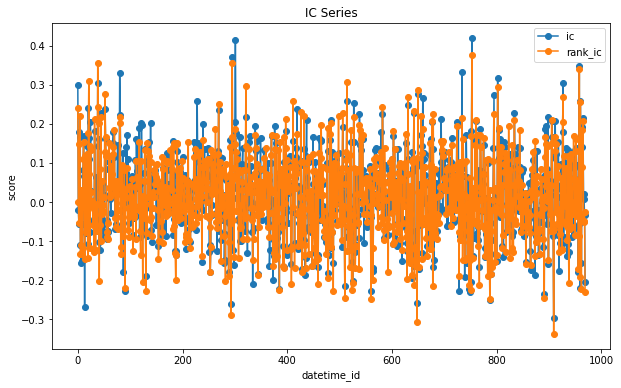

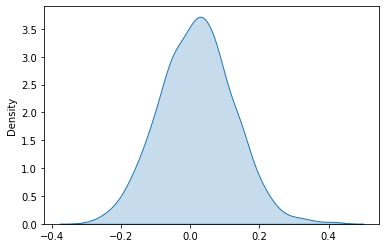

ic= 0.01812064347489512 icir= 0.16968163355921084 rank_ic= 0.013551528524547041 rank_icir= 0.12588714829139494


0.01699293879471772

In [5]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

In [6]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')

Accuracy of Prediction: 0.5283347430220409


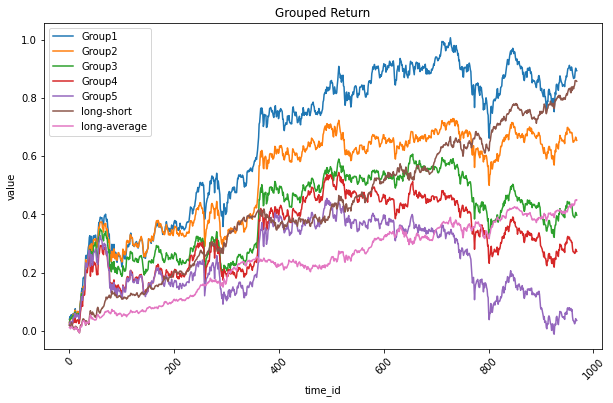

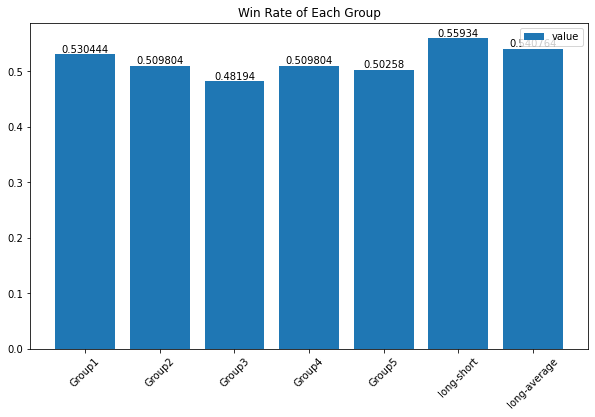

In [7]:
report.group_return_ana(pred, y_test)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "StrictTopKStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "buy": 0,  
            "sell": -0,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 1  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): 0.5547602459152221
std: 0.18918686772623672
E(r_benchmark): 0.4145573363202267
std_benchmark: 0.1728743456410088 

Cumulative Rate of Return: 0.7179213889668583
Cumulative Rate of Return(benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.37833582593130965 

Max Drawdown: -0.33753649722748635
Max Drawdown(benchmark): -0.5462600364770351 

Sharpe Ratio: 2.9319056909227355
Sortino Ratio: 0.5903369436912699
Information Ratio: 0.7410816156535578 

Beta: 0.8819852206908544
Profitable Days(%): 0.8802889576883385


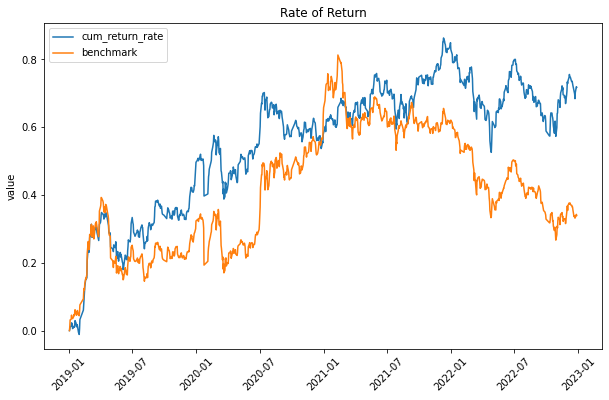

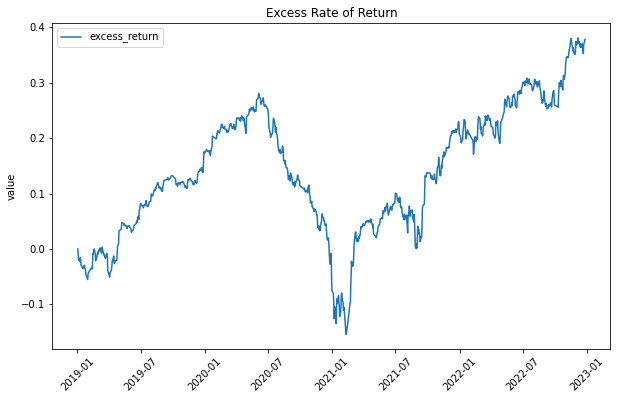

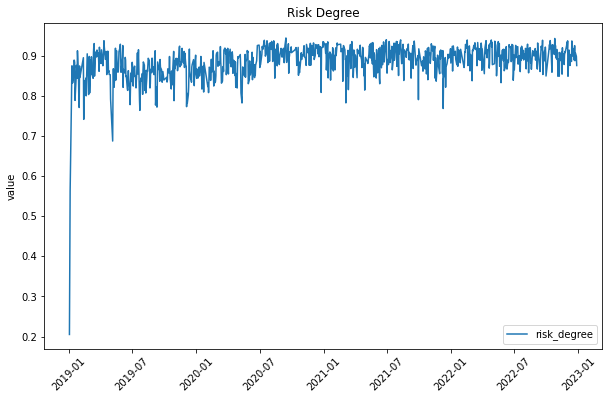

In [11]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节